# Use DLPy to Generate Heat Maps for Classified Images, Misclassified Images, Images by Filename, and Images by `image_id`


Heat maps are visualization tools that use color to indicate different values of interest. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps visualize which parts of an image are most useful to the model when predicting the class.

The following example uses SAS DLPy API to generate heat maps for correctly classified images and misclassified images.   

The examples to create heat maps use a trained model `model_r` that is reloaded from a saved SAS table. The examples use the Dolphin vs. Giraffe images for the classification and heat map generation tasks. The labeled images are from `animals with attributes 2`, a free data set for attribute-based classification and zero-shot learning at https://cvml.ist.ac.at/AwA2/. 

This example assumes that you have the images somewhere that CAS server can access. The input images are then processed for training and partitioned into train and test data sets. Next, use the pre-trained `model_r` image classification model to score the processed input dolphin and giraffe images. Then the example creates heat maps. First, generate and display heat maps for the test data set. Next, examine a method to generate heat maps for the test data set without processing and scoring the test images a second time.

The next example section contains code that shows how to generate heat maps for specific image types: correctly classified images, misclassified images, or all images (both correctly classified and misclassified).

The example assumes you have an active SAS CAS server.


In [1]:
%matplotlib inline

### Configure CAS and Import SWAT


SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
import swat
sess = swat.CAS(cashost, casport)

### Import DLPy ImageTable Module


Next, import the DLPy `ImageTable` module. This is a specialized CASTable class for image processing.
You use the DLPy `ImageTable` functions to create and load image tables for analysis.

In [3]:
import dlpy
from dlpy.images import ImageTable

<h3> Specify Path to Images, Then Name and Load the Image Table</h3>


After establishing an active SAS CAS session and importing the SWAT and DLPy modules, load the Dolphin vs. Giraffe images. The collection of DLPy examples all use the same image collection.

The folder structure for the giraffe and dolphin images in the example is as follows:

   * Giraffe_Dolphin
       * Giraffe
           * Giraffe image 1
           * Girrafe image 2
           * ...
       * Dolphin
           * Dolphin image 1
           * Dolphin image 2
           * ...       
           
In the following code, the value for `img_path` represents a fully-qualified directory path to the images. The path must be accessible by the CAS server session.  

In [4]:
img_path='/disk/linux/dlpy/Giraffe_Dolphin'
my_images = ImageTable.load_files(sess, path=img_path)

Use `image_summary()` to display a summary of the images and image metadata in `my_images`:

In [5]:
my_images.image_summary

jpg                   409
minWidth              170
maxWidth             1024
minHeight             127
maxHeight            1024
meanWidth         912.147
meanHeight        778.499
mean1stChannel    128.718
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.123
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    94.2449
min3rdChannel           0
max3rdChannel         255
dtype: object

The metadata summary shows 409 images of varying sizes, with image widths ranging from 170 to 1024 pixels, and with image heights ranging from 127 to 1025 pixels. 

<h3> Image Processing: Resize Images to a Fixed Size</h3>


The image processing task prepares the image data for model training. The input images are not all the same size. Use the `resize()` function to resize the images in `my_images` to 224 x 224 pixels.

In [6]:
my_images.resize(width=224)


Now check the resized images by using `show()` to display the first 8 images in an output table with 4 columns.

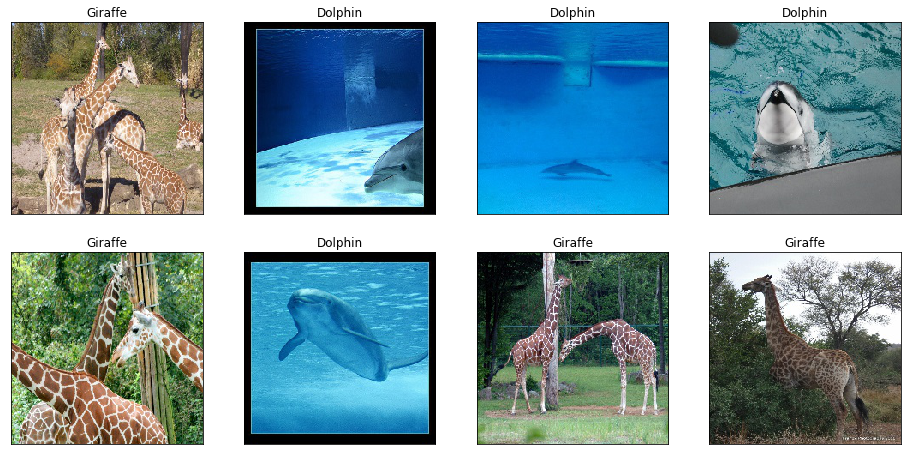

In [7]:
my_images.show(8, 4)

<h3>Split Image Data into Training and Testing Partitions</h3>


The code that follows imports the `two_way_split` class and partitions the data in the image table into two groups: a training image group and a testing image group. 

In [8]:
from dlpy.splitting import two_way_split

In the following code, 20% of the data is allocated for testing images `te_img`, and the remaining 80% of the data is allocated for training images `tr_img`. The code uses a random seed value of `123` when selecting observations for partitioning.

After creating test and train image partitions, perform a frequency analysis on the labeled images in the `tr_img` training partion. The frequency analysis helps you visualize how the images in the data are distributed.

In [9]:
tr_img, te_img = two_way_split(my_images, test_rate=20, seed=123)
tr_img.label_freq

Frequency for TRAIN_7QVZPG

         Level  Frequency
Dolphin      1        190
Giraffe      2        138

We can see in the output table that there are 190 dolphin images and 138 giraffe images, a total of 328 labeled images in the `tr_img` training partition. 

### Reload an Image Classification Model Saved in a SAS Table

The following code uses SAS DLPy to reload a model that was previously saved as a SAS table. This particular example reloads a CNN model trained to perform image classification. The model uses the dolphin and giraffe data.
 
Begin by configuring the DLPy environment for this task. First, import the `Model` and `Sequential` classes. Then import the functions contained in the DLPy `layers` and `applications` modules.

In [10]:
from dlpy import Model, Sequential
from dlpy.layers import * 
from dlpy.applications import *

After configuring the DLPy environment, use `Model()` to create a model named `model_r` and `load()` to load `model_r` at the path in `model_file` into memory.

In [11]:
model_r = Model(sess)
model_file = '/disk/linux/dlpy/Simple_CNN.sashdat'
model_r.load(path=model_file)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "simple_cnn" according to the model name in the table.
NOTE: Simple_CNN_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: Simple_CNN_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


### Use Reloaded Classification Model to Score Test Image Data

Now use the reloaded model `model_r` to score the test data set `te_img` and assess the classification accuracy. Use `predict()` to score the images in the test data set `te_img`.

In [22]:
model_r.predict(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            81
 1  Number of Observations Used            81
 2  Misclassification Error (%)      12.34568
 3                   Loss Error      0.395627

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  Valid_Res_DkUKsN    81        9   
 
                                             casTable  
 0  CASTable('Valid_Res_DkUKsN', caslib='CASUSER(e...  

+ Elapsed: 0.438s, user: 7s, sys: 1.21s, mem: 1.36e+03mb

### Generate Heat Maps for Test Data Set




Heat maps are used to visualize to indicateto indicate which regions of an image are most important using color codes. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps help visualize which parts of an image are most useful to the model when predicting the correct class.  

The following code to generate heat maps uses the score results from the CNN network `model_r` and the test data set `te_images`. 56 x 56 pixel masks over the image are used with a step size of 8 pixels. 1 GPU (GPU1) is enabled for processing.

Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 5 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_8UZOQH contains compressed images.


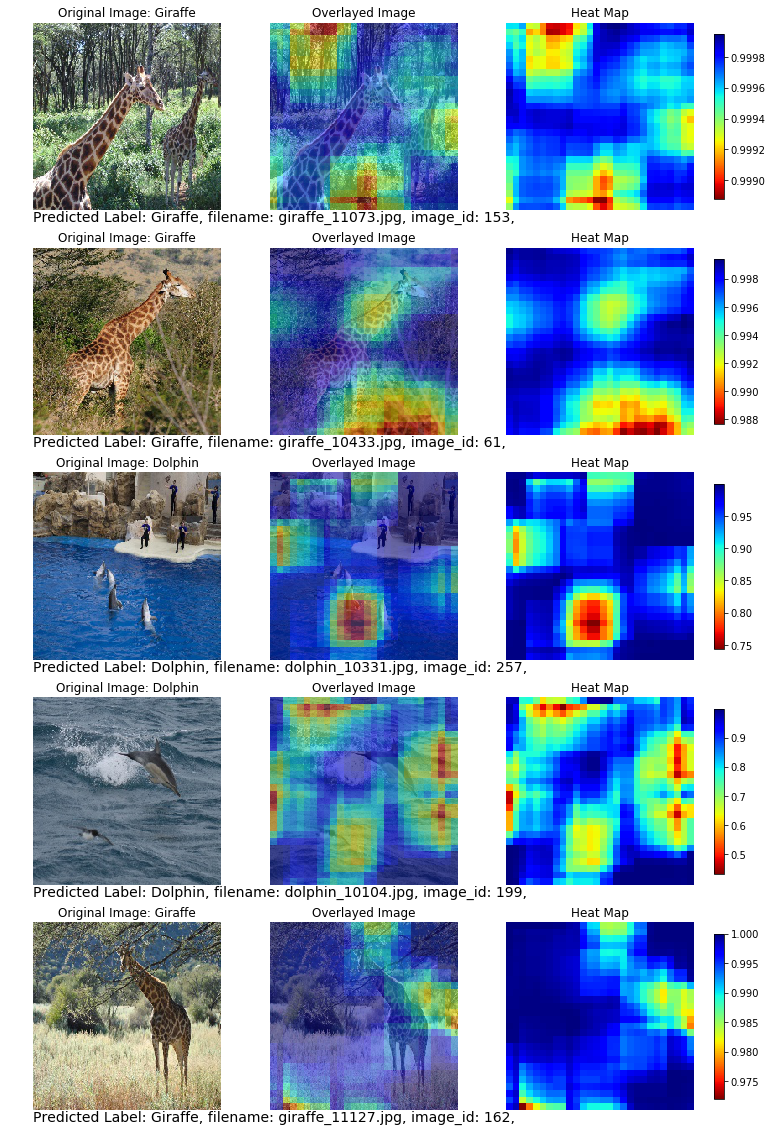

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_8uzOQh from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.000133          0.999867  giraffe_11073.jpg  153   
1   Giraffe          0.001989          0.998011  giraffe_10433.jpg   61   
2   Dolphin          0.898225          0.101775  dolphin_10331.jpg  257   
3   Dolphin          0.940602          0.059397  dolphin_10104.jpg  199   
4   Giraffe          0.000027          0.999973  giraffe_11127.jpg  162   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   

                                            heat_map  
0  [[0.9995775818824768, 0.9995775818824768, 0.99...  
1  [[0.9993031024932861, 0.9993031024932861, 0.99...  
2  [[0.9956435561180115, 0.9956435561180115, 0.99...  
3  [[0.9683835506439209, 0.9683835506439209, 0.96...  
4  [[0.9999996423721313, 0.9999996423721313, 0.99...

In [23]:
model_r.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, gpu=dict(devices=[1]))

The results above show heat maps and classification prediction probabilities for five of the scored images, selected at random.

<h3>Generate Heat Maps Without Specifying Input Data Set</h3>

If you just scored an image classification model and want to generate heat maps for the scored images, you can avoid avoid unnecessary model processing when you generate the heat maps.  If your function call to `heat_map_analysis()` for a model such as `model_r` does not contain an input data specification, by default the function will generate heat maps using the most recent score data from the named model. 

The following code generates heat maps for the CNN network `model_r` using the results from the most recently scored `model_r` data. The most recently scored results were those for `te_img`. No input data was specified in the function call, so images in `te_img` are used. 

56 x 56 pixel masks over the image are used with a step size of 8 pixels. This example instance does not use GPU processing. The number of images are limited to three.

Using results from model.predict()
NOTE: The number of images in the table is too large, only 3 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_HUO9SW contains compressed images.


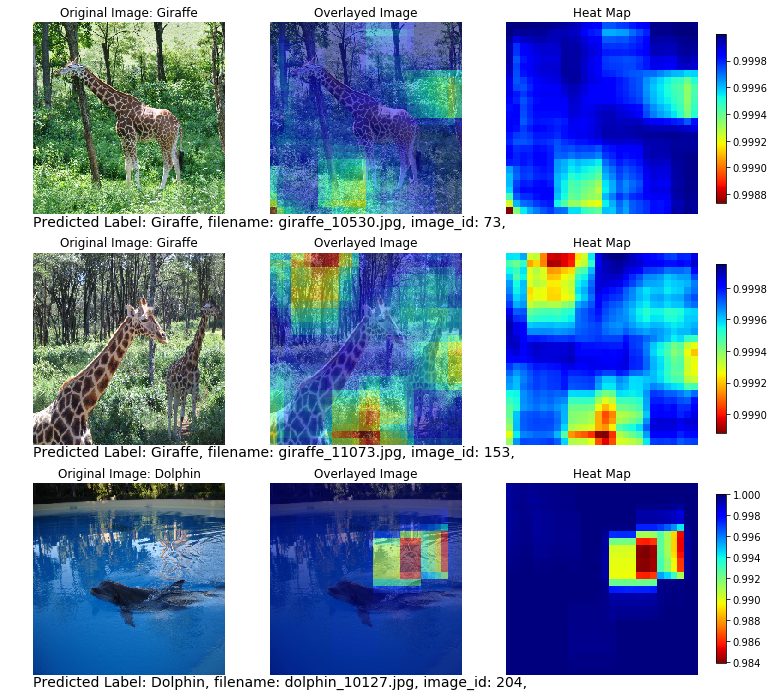

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_Huo9sw from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.000026          0.999974  giraffe_10530.jpg   73   
1   Giraffe          0.000133          0.999867  giraffe_11073.jpg  153   
2   Dolphin          0.999961          0.000039  dolphin_10127.jpg  204   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   

                                            heat_map  
0  [[0.9999998807907104, 0.9999998807907104, 0.99...  
1  [[0.9995775818824768, 0.9995775818824768, 0.99...  
2  [[0.9995706677436829, 0.9995706677436829, 0.99...

In [27]:
model_r.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, max_display=3)

<h3>Display Heat Maps Based on Image Classification Result Types</h3>

Thus far, the randomly display heat maps have all been for correctly classified images. You can control the type of heat map images displayed when generating heat maps by providing values for the `img_type` parameter. The `img_type` parameter can contain three values: `C` to display only correct classifications, `M` to display only misclassified images, or the default value, `A`, which displays results for both correctly classified and misclassified images.

Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 3 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_OE6SYL contains compressed images.


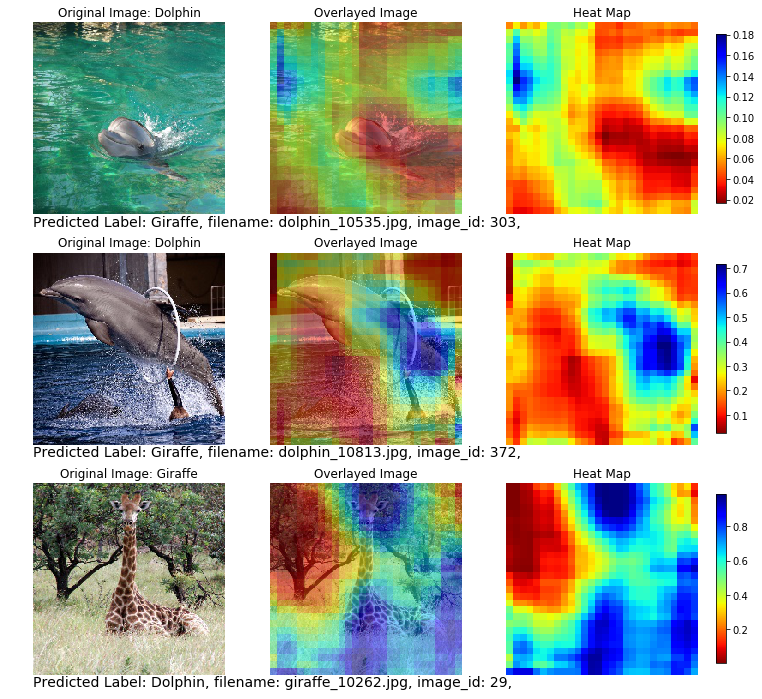

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_oE6SyL from caslib CASUSER(ethem_kinginthenorth).


In [28]:
misclass = model_r.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, img_type='M', max_display=3)

In [29]:
misclass

I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.044695          0.955305  dolphin_10535.jpg  303   
1   Giraffe          0.158259          0.841741  dolphin_10813.jpg  372   
2   Dolphin          0.610146          0.389854  giraffe_10262.jpg   29   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   

                                            heat_map  
0  [[0.055270396173000336, 0.055270396173000336, ...  
1  [[0.03745615854859352, 0.03745615854859352, 0....  
2  [[0.002698448020964861, 0.002698448020964861, ...

### Filtering images to be visualized


Suppose you want to generate a list of the some or all of the filenames of the misclassified images in the most recent scored data set. 

The following code uses `_filename_0` and the `tolist()` function to return a list of all of the misclassified images in the results image table:

In [30]:
misclass['_filename_0'].tolist()

['dolphin_10535.jpg', 'dolphin_10813.jpg', 'giraffe_10262.jpg']

If you like, you can customize the list.

In [31]:
two_misclass_names = misclass['_filename_0'].tolist()[:2]

If you submit the variable `two_misclass_names` to DLPy, it returns the names of the two image files that were saved.

In [32]:
two_misclass_names

['dolphin_10535.jpg', 'dolphin_10813.jpg']

You can use the `filename` parameter with the `heat_map_analysis()` function to submit either a single filename or the name of a variable containing a file list. 

 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(ethem_kinginthenorth).
Running prediction ...
... finished running prediction
NOTE: Table VALID_RES_COMPLETE_F7VDQE contains compressed images.


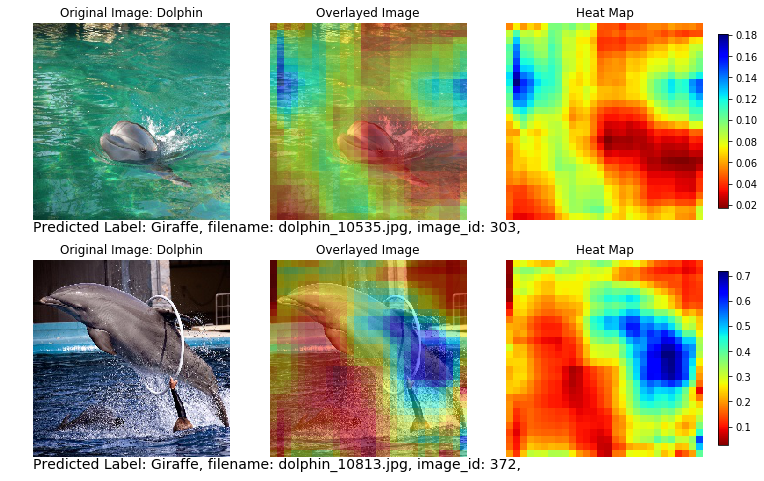

NOTE: Cloud Analytic Services dropped table Valid_Res_Complete_f7vdQE from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.044695          0.955305  dolphin_10535.jpg  303   
1   Giraffe          0.158259          0.841741  dolphin_10813.jpg  372   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   

                                            heat_map  
0  [[0.055270396173000336, 0.055270396173000336, ...  
1  [[0.03745592385530472, 0.03745592385530472, 0....

In [33]:
model_r.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, img_type='M', filename = two_misclass_names)

<h3>Another way of Filtering Images to be visualized</h3>




The following code creates a variable `my_list` and populates that variable with a list of the first 4 image `_id_` values in the test data set `te_img`:

In [40]:
my_list = te_img['_id_'].tolist()[1:5]

Submitting the variable name `my_list` to the session returns the list of 4 (from first to fifth) stored image `_id_` values:

In [42]:
my_list

[153, 95, 234, 352]

The output returns the 4 selected values for `image_id`.

Now use `heat_map_analysis()` to generate a heat map results table, using a subset of selected images from both correctly classified and misclassified observations in the `te_img` test data set. The selected images are identified by the associated `image_id` values that are stored in the `my_list` variable.    

The resulting output should be an image table with heat maps for the four images identified as `image_id: 435`, `image_id: 285`, `image_id: 962`, and `image_id: 1362`. 

 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(ethem_kinginthenorth).
Running prediction ...
... finished running prediction
NOTE: Table VALID_RES_COMPLETE_PPE97Q contains compressed images.


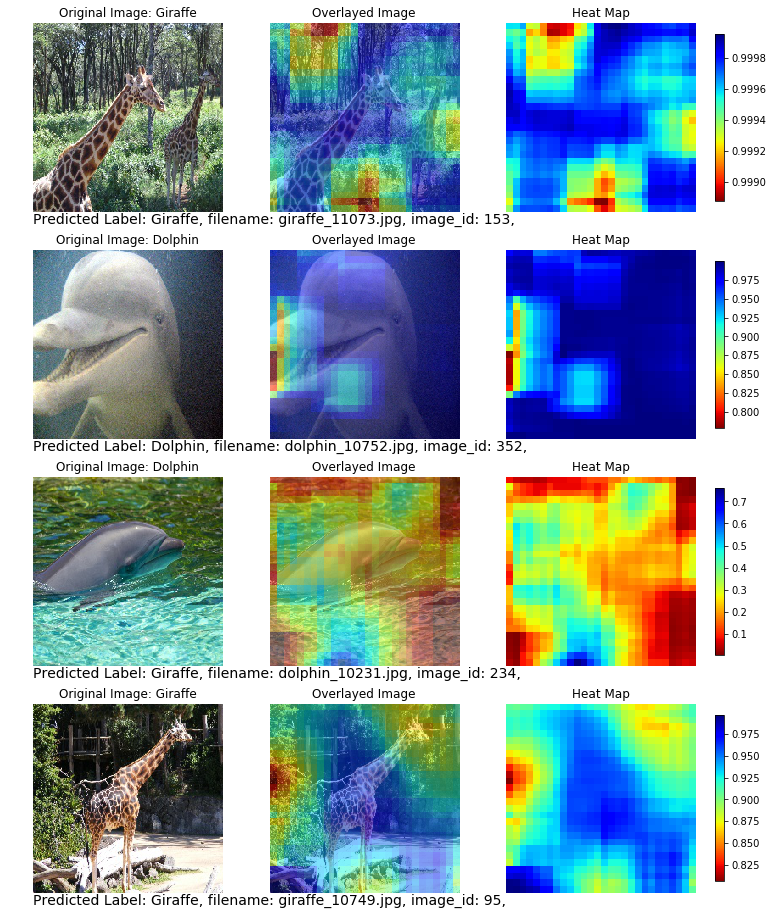

NOTE: Cloud Analytic Services dropped table Valid_Res_Complete_PpE97Q from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.000133          0.999867  giraffe_11073.jpg  153   
1   Dolphin          0.986216          0.013784  dolphin_10752.jpg  352   
2   Giraffe          0.109392          0.890608  dolphin_10231.jpg  234   
3   Giraffe          0.061004          0.938996  giraffe_10749.jpg   95   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   

                                            heat_map  
0  [[0.9995775818824768, 0.9995775818824768, 0.99...  
1  [[0.9741463661193848, 0.9741463661193848, 0.97...  
2  [[0.08254057168960571, 0.08254057168960571, 0....  
3  [[0.9094592928886414, 0.9094592928886414, 0.90...

In [43]:
model_r.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, img_type='A', image_id = my_list)

If you desire, you can reference individual values when multiple values are stored in a variable like `my_list`. Recall the variable `my_list` and use the only first image

In [45]:
single = my_list[0]

 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(ethem_kinginthenorth).
Running prediction ...
... finished running prediction
NOTE: Table VALID_RES_COMPLETE_WOA43V contains compressed images.


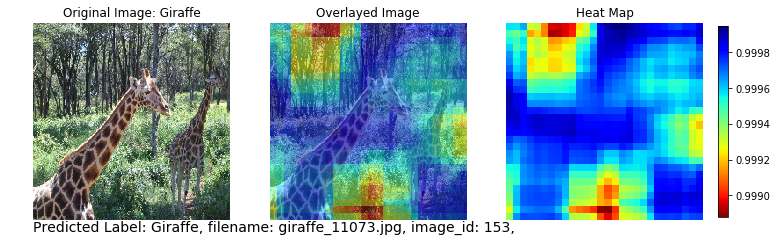

NOTE: Cloud Analytic Services dropped table Valid_Res_Complete_Woa43v from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.000133          0.999867  giraffe_11073.jpg  153   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   

                                            heat_map  
0  [[0.9995775818824768, 0.9995775818824768, 0.99...

In [46]:
model_r.heat_map_analysis(data=te_img, 
                          mask_width=56, mask_height=56, step_size=8, 
                          img_type='A', 
                          image_id = single, 
                          gpu=dict(devices=[1]))

The output above shows the heat map for the scored `model_r` image where `image_id=153`. The file `giraffe_11073.jpg` with `_id_` of 435 is correctly classified as a giraffe.